## 돌리는거

In [1]:
import numpy as np
import wfdb
import _pickle as pickle

CENSD

In [2]:
import wfdb
import numpy as np
import pickle

def prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
    with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
    Muscle Artifact (MA) noises are added randomly.
    Expands the final noise matrix to shape (2, 650000, 1).
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Initialize storage for combined noise across channels
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Extract channel-specific noise data
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
        # Initialize combined noise array for this channel
        combined_channel_noise = np.zeros(bw_noise.shape)

        # Divide the noise data into chunks (simulating random time intervals)
        chunk_size = 10000  # Random time chunk size
        num_chunks = len(bw_noise) // chunk_size
        seed = 1234  # 원하는 값을 설정
        np.random.seed(seed=seed)
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = start_idx + chunk_size

            # Include BW noise by default
            bw_chunk = bw_noise[start_idx:end_idx]

            # Randomly decide whether to include EM and MA noises
            em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
            ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
            # Generate noise for this chunk
            chunk_noise = (
                bw_chunk +  # BW noise is always included
                em_flag * em_noise[start_idx:end_idx] +
                ma_flag * ma_noise[start_idx:end_idx]
            )

            # Apply the chunk noise to the combined noise array
            combined_channel_noise[start_idx:end_idx] += chunk_noise
        
        # Expand dimensions to make it (650000, 1) for this channel
        combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

        # Append the combined noise for this channel
        combined_noise.append(combined_channel_noise)

    # Stack the noises for all channels to shape (2, 650000, 1)
    combined_noise = np.stack(combined_noise, axis=0)

    # Save combined noise data as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print(f'Final combined noise shape: {combined_noise.shape}')
    print('Realistic NSTDB noise data with Baseline Wander always included saved as pickle')

In [3]:
prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

[DEBUG] Processing channel 1: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
[DEBUG] Processing channel 2: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
Final combined noise shape: (2, 650000, 1)
Realistic NSTDB noise data with Baseline Wander always included saved as pickle


In [4]:
import numpy as np
from scipy.fft import fft
import glob
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle


def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    
    Parameters:
    inputs: 입력 신호 (원본 신호, 2D 배열 - (배치 크기, 샘플 수))
    n: FFT 샘플 수
    fs: 샘플링 주파수 (예: 360 Hz)
    
    Returns:
    주파수 도메인에서 얻은 신호 (FFT), time-domain과 동일한 크기
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        # Magnitude 값을 두 배로 늘려 time-domain과 동일한 shape으로 맞춤 (512)
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier(samples, fs=360):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)

    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")
    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    # 노이즈 인덱스 저장 리스트
    noise_indices_train = []
    noise_indices_test = []
    sn_train = []
    sn_test = []
    
    skip_beats = 0
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb.keys())} signals to process.")

    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue

            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            if signal_name in test_set:
                beats_test.append(b_np)
                fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # To ensure equal selection of channels
    # Adding noise to train
    for beat_idx, beat in enumerate(beats_train):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택

        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = 0  # 1부터 7까지 순차적으로 선택, 근데 0번째것만 하기로 함함
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        if noise_max_value == 0:
            Ase = 1  # 기본값 설정
        else:
            Ase = noise_max_value / beat_max_value
        alpha = rnd_train[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
        
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택
        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = 0  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        if noise_max_value == 0:
            Ase = 1  # 기본값 설정
            print('noise_max_value is 0')
        else:
            Ase = noise_max_value / beat_max_value
        alpha = rnd_test[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0


    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    # Fourier 정보도 포함된 주파수 도메인 데이터셋 생성
    F_train_x = np.array(fourier_train_x)[valid_train_indices]
    F_test_x = np.array(fourier_test_x)[valid_test_indices]
    F_train_y = np.array(fourier_train_y)[valid_train_indices]
    F_test_y = np.array(fourier_test_y)[valid_test_indices]

    # Shape을 time-domain과 동일하게 확장
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]
    
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test

In [5]:
# Unpack the dataset
Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, total 

In [29]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [7]:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')



In [45]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [46]:
with open('1220/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('1220/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('1220/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('1220/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('1220/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0128/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 87.842 (149.923) | 0.997 (0.816) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 78.701 (135.916) | 0.958 (0.817) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        |  6.821 (10.051)  | 0.497 (0.330) | 55.969 (33.130) | 0.874 (0.128) | 7.297 (3.390)  |
|       FCN-DAE       |  9.175 (13.267)  | 0.547 (0.382) | 72.853 (46.337) | 0.803 (0.194) | 5.742 (3.735)  |
|      DeepFilter     |  6.680 (9.011)   | 0.440 (0.327) | 60.646 (38.037) | 0.860 (0.138) | 6.999 (3.610)  |
|   AttentionSkipDAE  |  5.777 (9.137)   | 0.388 (0.280) | 48.260 (25.741) | 0.898 (0.106) | 8

CLEAN VS NOISY

In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def ecg_view_separate(ecg_segments, ecg_blw_segments, model_name,
                      signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments]) 
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])

    # Custom Y-Limits for CLEAN signal
    clean_y_min = ecg_concat.min()
    clean_y_max = ecg_concat.max()

    # Plot NOISY
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ecg_blw_concat, color='red', label='Noisy Signal', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    ax.legend(loc='upper right', fontsize=20, frameon=True, framealpha=0.8, edgecolor='black')
    ax.set_xlabel('Samples (N)', fontsize=30, labelpad=15, fontweight='bold')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, labelpad=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title("Noisy ECG Signal", fontsize=35, pad=20, fontweight='bold')
    filename = f"NOISY_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

    # Plot CLEAN
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ecg_concat, color='red', label='Clean Signal', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    ax.legend(loc='upper right', fontsize=20, frameon=True, framealpha=0.8, edgecolor='black')
    ax.set_xlabel('Samples (N)', fontsize=30, labelpad=15, fontweight='bold')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, labelpad=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylim([clean_y_min, clean_y_max])  # Adjust Y-axis to fit the CLEAN signal tightly
    ax.set_title("Clean ECG Signal", fontsize=35, pad=20, fontweight='bold')
    filename = f"CLEAN_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 12
signals_index = [1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039]  # Indices of segments to plot

# Load model results (e.g., Transformer_COMBDAE)
with open("1220/test_results_Transformer_COMBDAE.pkl", 'rb') as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Prepare segments for plotting
ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
ecg_signals2plot = [y_test[i] for i in signals_index]    # Original segments

# Generate separate plots for NOISY and CLEAN
ecg_view_separate(ecg_segments=ecg_signals2plot,
                  ecg_blw_segments=ecgbl_signals2plot,
                  model_name='ECG_Comparison',
                  signal_name='Example_Signal',
                  save_dir='fig1',
                  num_segments=segments_to_plot)


Saved: fig1/NOISY_Example_Signal_ECG_Comparison_Segments_12.png
Saved: fig1/CLEAN_Example_Signal_ECG_Comparison_Segments_12.png


In [31]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def ecg_view_comparison(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                        noise_indices=None, signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Plot comparison
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(ecg_concat, 'b-', label='Original ECG (Ground Truth)', lw=1.5)  # 검은색 선
    ax.plot(ecg_dl_concat, 'r-', label=f'{model_name} Filtered ECG', lw=3)  # 빨간색 선
    
    # Grid, labels, and legend
    ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Samples (N)', fontsize=42)
    ax.set_ylabel('Amplitude (au)', fontsize=42)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.set_title(f"Signal Comparison for {model_name}", fontsize=45, fontweight='bold')
    ax.legend(loc='upper right', fontsize=35)
    
    # # 축 범위 제한
    # ax.set_xlim([0, len(ecg_concat) // 2])
    # ax.set_ylim([-2, 2])

    # Save the figure
    filename = f"Comparison_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close figure to free memory
    print(f"Saved: {filepath}")


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']

model_results = {}
for model_name in dl_experiments:
    file_path = f"1220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1208/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1208/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 8
signals_index = [1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039]  # Indices of segments to plot
noise_indices = [i for i in signals_index]  # Example noise indices

# Loop through each model and generate plots
for model_name, (X_test, y_test, y_pred) in model_results.items():
    # Prepare segments for plotting
    ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
    ecg_signals2plot = [y_test[i] for i in signals_index]  # Original segments
    dl_signals2plot = [y_pred[i] for i in signals_index]  # Model-filtered segments

    # Generate comparison plot for the model
    ecg_view_comparison(ecg_segments=ecg_signals2plot,
                        ecg_blw_segments=ecgbl_signals2plot,
                        ecg_dl_segments=dl_signals2plot,
                        model_name=model_name,
                        noise_indices=noise_indices,
                        signal_name=signal_name,
                        save_dir='fig5',
                        num_segments=segments_to_plot)


Saved: fig5/Comparison_Example_Signal_DRNN_Segments_8.png
Saved: fig5/Comparison_Example_Signal_FCN-DAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_DeepFilter_Segments_8.png
Saved: fig5/Comparison_Example_Signal_AttentionSkipDAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_Transformer_DAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_Transformer_COMBDAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_FIR_Filter_Segments_8.png
Saved: fig5/Comparison_Example_Signal_IIR_Filter_Segments_8.png


밑의 코드로 latex로 바로 정리 가능능

In [66]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE']
model_results = {}

# Load FIR and IIR results
with open('1220/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR-Filter"] = pickle.load(input)

with open('1220/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR-Filter"] = pickle.load(input)
    
for model_name in dl_experiments:
    file_path = f"1220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)
with open('0128/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    model_results["Transformer-COMBDAE"] = pickle.load(input)


# Load noise levels
rnd_test = np.load("rnd_test.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model: FIR-Filter
Processing results for model: IIR-Filter
Processing results for model: DRNN
Processing results for model: FCN-DAE
Processing results for model: DeepFilter
Processing results for model: AttentionSkipDAE
Processing results for model: Transformer_DAE
Processing results for model: Transformer-COMBDAE
Saved SSD table to results_tables_final/SSD_results.tex
Saved MAD table to results_tables_final/MAD_results.tex
Saved PRD table to results_tables_final/PRD_results.tex
Saved COS_SIM table to results_tables_final/COS_SIM_results.tex
Saved SNR table to results_tables_final/SNR_results.tex


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from vg_beat_detectors import FastNVG  # Import the FastNVG detector


# def calculate_rr_accuracy_with_mape(y_test, y_pred, sampling_rate=360, debug_samples=5):
#     absolute_errors = []
#     percentage_errors = []
#     debug_logs = []
#     debug_plots = []

#     # Initialize the FastNVG detector
#     detector = FastNVG(sampling_frequency=sampling_rate)

#     for idx, (ground_truth, denoised) in enumerate(zip(y_test, y_pred)):
#         ground_truth = ground_truth.flatten()
#         denoised = denoised.flatten()

#         # Detect R-peaks using FastNVG
#         gt_peaks = detector.find_peaks(ground_truth)
#         denoised_peaks = detector.find_peaks(denoised)

#         gt_times = np.array(gt_peaks) / sampling_rate
#         denoised_times = np.array(denoised_peaks) / sampling_rate

#         if len(gt_times) == 0 or len(denoised_times) == 0:
#             debug_logs.append({
#                 "Sample": idx,
#                 "Error": "Insufficient R-peaks detected",
#                 "Ground Truth Times": gt_times.tolist(),
#                 "Denoised Times": denoised_times.tolist()
#             })
#             continue

#         gt_time = gt_times[0]
#         denoised_time = denoised_times[0]

#         absolute_error = abs(gt_time - denoised_time)
#         percentage_error = (absolute_error / gt_time) * 100 if gt_time != 0 else np.nan

#         absolute_errors.append(absolute_error)
#         percentage_errors.append(percentage_error)

#         if len(debug_plots) < debug_samples:
#             debug_plots.append({
#                 "Sample": idx,
#                 "Ground Truth": ground_truth,
#                 "Denoised": denoised,
#                 "Ground Truth Time": gt_time,
#                 "Denoised Time": denoised_time,
#                 "Absolute Error": absolute_error,
#                 "Percentage Error": percentage_error
#             })

#     mean_absolute_error = np.mean(absolute_errors) if absolute_errors else float('nan')
#     mean_absolute_percentage_error = np.mean(percentage_errors) if percentage_errors else float('nan')

#     return {
#         "Mean Absolute Error (s)": mean_absolute_error,
#         "Mean Absolute Percentage Error (%)": mean_absolute_percentage_error,
#     }, debug_logs, debug_plots

def plot_concatenated_r_peaks(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig7", max_samples=8):
    """
    Concatenate samples and plot R-peak detection for ground truth and denoised signals.

    :param y_test: Ground truth signals.
    :param y_pred: Denoised signals.
    :param model_name: Name of the model.
    :param sampling_rate: Sampling rate of the signals.
    :param save_dir: Directory to save the plots.
    :param max_samples: Maximum number of samples to concatenate.
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Concatenate a limited number of samples
    y_test_concat = np.concatenate([y.flatten() for y in y_test[1032:1032+max_samples]])
    y_pred_concat = np.concatenate([y.flatten() for y in y_pred[1032:1032+max_samples]])
    
    # Initialize the FastNVG detector
    detector = FastNVG(sampling_frequency=sampling_rate)
    gt_peaks = detector.find_peaks(y_test_concat)
    denoised_peaks = detector.find_peaks(y_pred_concat)

    # Plot the concatenated signals
    plt.figure(figsize=(24, 16))

    # Add red grid lines
    y_min, y_max = min(y_test_concat.min(), y_pred_concat.min()), max(y_test_concat.max(), y_pred_concat.max())
    signal_length = len(y_test_concat)
    
    for x in np.arange(0, signal_length, sampling_rate * 0.2):  # Vertical bold lines every 0.2s
        plt.axvline(x=x, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
    for x in np.arange(0, signal_length, sampling_rate * 0.04):  # Vertical thin lines every 0.04s
        plt.axvline(x=x, color='red', linestyle='-', alpha=0.3, linewidth=0.5)
    # for y in np.arange(y_min, y_max, 0.5):  # Horizontal bold lines every 0.5mV
    #     plt.axhline(y=y, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
    for y in np.arange(y_min, y_max, 0.1):  # Horizontal thin lines every 0.1mV
        plt.axhline(y=y, color='red', linestyle='-', alpha=0.3, linewidth=0.5)

    # Plot Ground Truth signal
    plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=2)
    plt.scatter(gt_peaks, y_test_concat[gt_peaks], color="blue", s=100, label="R-Peaks (Ground Truth)", zorder=5)  # 크기 증가 및 색상 변경

    # Plot Denoised signal
    plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=2)
    plt.scatter(denoised_peaks, y_pred_concat[denoised_peaks], color="red", s=100, label="R-Peaks (Denoised)", zorder=5)

    # Draw dashed lines for R-peak differences and annotate Δ values
    for gt, den in zip(gt_peaks, denoised_peaks):
        plt.axvline(x=gt, color="blue", linestyle="--", alpha=0.5)
        plt.axvline(x=den, color="red", linestyle="--", alpha=0.5)
        delta_time = abs(gt - den) / sampling_rate
        plt.text((gt + den) / 2, max(y_test_concat.max(), y_pred_concat.max()) * 0.8,
                 f"Δ = {delta_time:.2f}s", ha="center", va="bottom", fontsize=10, color="purple")

    # Add labels, legend, and grid
    plt.title(f"Concatenated R-Peak Detection - {model_name}", fontsize=24, fontweight="bold")
    plt.xlabel("Samples (N)", fontsize=20)
    plt.ylabel("Amplitude (au)", fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis limits to start at 0 and end at the signal length
    plt.xlim(0, signal_length)

    # Save the plot
    save_path = os.path.join(save_dir, f"{model_name}_R_Peaks_Comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved concatenated R-peak plot for {model_name}: {save_path}")

# Example usage
for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)
    # metrics, debug_logs, debug_plots = calculate_rr_accuracy_with_mape(y_test, y_pred)

    # print(f"Model: {model_name}\nMetrics: {metrics}\n")
    plot_concatenated_r_peaks(y_test, y_pred, model_name)


Saved concatenated R-peak plot for DRNN: fig7/DRNN_R_Peaks_Comparison.png
Saved concatenated R-peak plot for FCN-DAE: fig7/FCN-DAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for DeepFilter: fig7/DeepFilter_R_Peaks_Comparison.png
Saved concatenated R-peak plot for AttentionSkipDAE: fig7/AttentionSkipDAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for Transformer_DAE: fig7/Transformer_DAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for Transformer_COMBDAE: fig7/Transformer_COMBDAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for FIR_Filter: fig7/FIR_Filter_R_Peaks_Comparison.png
Saved concatenated R-peak plot for IIR_Filter: fig7/IIR_Filter_R_Peaks_Comparison.png


### r peak

In [61]:
# import numpy as np
# from scipy.spatial import KDTree
# import matplotlib.pyplot as plt
# import os
# from vg_beat_detectors import FastNVG


# def calculate_peak_detection_accuracy(y_test, y_pred, sampling_rate=360, tolerance=0.05):
#     """
#     Calculate Peak Detection Accuracy using matched R-peaks between ground truth and denoised signals.
#     :param y_test: Ground truth ECG signals.
#     :param y_pred: Denoised ECG signals.
#     :param sampling_rate: Sampling rate of the signals.
#     :param tolerance: Time tolerance for matching peaks (in seconds).
#     :return: Metrics (Accuracy, Precision, Recall, F1-score).
#     """
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     tp, fp, fn = 0, 0, 0

#     for ground_truth, denoised in zip(y_test, y_pred):
#         ground_truth = ground_truth.flatten()
#         denoised = denoised.flatten()

#         # Detect R-peaks
#         gt_peaks = detector.find_peaks(ground_truth)
#         denoised_peaks = detector.find_peaks(denoised)

#         gt_times = np.array(gt_peaks) / sampling_rate
#         denoised_times = np.array(denoised_peaks) / sampling_rate

#         # Build a KDTree for fast nearest-neighbor search
#         if len(gt_times) > 0 and len(denoised_times) > 0:
#             tree = KDTree(gt_times.reshape(-1, 1))
#             distances, indices = tree.query(denoised_times.reshape(-1, 1))

#             # Match peaks within tolerance
#             for dist, idx in zip(distances, indices):
#                 if dist <= tolerance:
#                     tp += 1  # True Positive
#                 else:
#                     fp += 1  # False Positive

#             # Count unmatched ground truth peaks as False Negatives
#             matched_gt = set(indices[distances <= tolerance])
#             fn += len(gt_times) - len(matched_gt)
#         else:
#             # If no R-peaks detected in one of the signals
#             fn += len(gt_times)
#             fp += len(denoised_times)

#     # Calculate metrics
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
#     accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

#     return {
#         "Accuracy": accuracy,
#         "Precision": precision,
#         "Recall": recall,
#         "F1-Score": f1_score,
#     }


# def plot_concatenated_r_peaks(y_test, y_pred, model_name, sampling_rate=360, save_dir="plots", max_samples=8):
#     # Ensure save directory exists
#     os.makedirs(save_dir, exist_ok=True)
    
#     # Concatenate a limited number of samples
#     y_test_concat = np.concatenate([y.flatten() for y in y_test[1032:1032+max_samples]])
#     y_pred_concat = np.concatenate([y.flatten() for y in y_pred[1032:1032+max_samples]])
    
#     # Initialize the FastNVG detector
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     gt_peaks = detector.find_peaks(y_test_concat)
#     denoised_peaks = detector.find_peaks(y_pred_concat)

#     # Plot the concatenated signals
#     plt.figure(figsize=(20, 10))

#     # Plot Ground Truth signal
#     plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=2)
#     plt.scatter(gt_peaks, y_test_concat[gt_peaks], color="red", label="R-Peaks (Ground Truth)", zorder=5)

#     # Plot Denoised signal
#     plt.plot(y_pred_concat, label="Denoised Signal", color="green", linewidth=2)
#     plt.scatter(denoised_peaks, y_pred_concat[denoised_peaks], color="orange", label="R-Peaks (Denoised)", zorder=5)

#     # Draw dashed lines for R-peak differences
#     for gt, den in zip(gt_peaks, denoised_peaks):
#         plt.axvline(x=gt, color="red", linestyle="--", alpha=0.5)
#         plt.axvline(x=den, color="orange", linestyle="--", alpha=0.5)

#     # Add labels, legend, and grid
#     plt.title(f"Concatenated R-Peak Detection - {model_name}", fontsize=20)
#     plt.xlabel("Sample Index", fontsize=16)
#     plt.ylabel("Amplitude", fontsize=16)
#     plt.legend(fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.7)

#     # Save the plot
#     save_path = os.path.join(save_dir, f"{model_name}_R_Peaks_Comparison.png")
#     plt.savefig(save_path, dpi=300)
#     plt.close()
#     print(f"Saved concatenated R-peak plot for {model_name}: {save_path}")


# # Loop through each model and calculate metrics
# for model_name, test_model in model_results.items():
#     y_test, y_pred = test_model[1], test_model[2]

#     y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
#     y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

#     metrics = calculate_peak_detection_accuracy(y_test, y_pred)
#     print(f"Model: {model_name}\nMetrics: {metrics}\n")

#     plot_concatenated_r_peaks(y_test, y_pred, model_name)


GT에 R-peak가 없거나 Denoised 신호에만 R-peak가 존재하는 경우를 처리하는 논리를 추가

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
from vg_beat_detectors import FastNVG


def calculate_peak_detection_accuracy(y_test, y_pred, sampling_rate=360, tolerance=0.05):
    """
    Calculate Peak Detection Accuracy assuming Ground Truth R-peaks always exist.
    :param y_test: Ground truth ECG signals.
    :param y_pred: Denoised ECG signals.
    :param sampling_rate: Sampling rate of the signals.
    :param tolerance: Time tolerance for matching peaks (in seconds).
    :return: Metrics (Accuracy, Precision, Recall, F1-score).
    """
    detector = FastNVG(sampling_frequency=sampling_rate)
    tp, fp, fn = 0, 0, 0

    for ground_truth, denoised in zip(y_test, y_pred):
        ground_truth = ground_truth.flatten()
        denoised = denoised.flatten()

        # Detect R-peaks
        gt_peaks = detector.find_peaks(ground_truth)
        denoised_peaks = detector.find_peaks(denoised)

        gt_times = np.array(gt_peaks) / sampling_rate
        denoised_times = np.array(denoised_peaks) / sampling_rate

        # If both GT and denoised peaks exist
        if len(gt_times) > 0 and len(denoised_times) > 0:
            matched_gt = set()
            for den_time in denoised_times:
                # Check if any GT falls within tolerance
                matches = np.abs(gt_times - den_time) <= tolerance
                if any(matches):
                    tp += 1  # Matched peaks are True Positives
                    matched_gt.add(np.where(matches)[0][0])  # Store matched GT index
                else:
                    fp += 1  # Unmatched denoised peak is a False Positive

            # GT peaks not matched by any denoised peaks are False Negatives
            fn += len(gt_times) - len(matched_gt)
        else:
            # If only one of them has R-peaks
            fn += len(gt_times)
            fp += len(denoised_times)

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
    }


def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig8", max_samples=8):
    """
    Plot R-peak detection results including TP, FP, FN.
    :param y_test: Ground truth ECG signals.
    :param y_pred: Denoised ECG signals.
    :param model_name: Name of the model.
    :param sampling_rate: Sampling rate of the signals.
    :param save_dir: Directory to save the plot.
    :param max_samples: Number of samples to concatenate for visualization.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Concatenate a limited number of samples
    y_test_concat = np.concatenate([y.flatten() for y in y_test[:max_samples]])
    y_pred_concat = np.concatenate([y.flatten() for y in y_pred[:max_samples]])

    # Detect R-peaks
    detector = FastNVG(sampling_frequency=sampling_rate)
    gt_peaks = detector.find_peaks(y_test_concat)
    denoised_peaks = detector.find_peaks(y_pred_concat)

    # Convert to time
    gt_times = np.array(gt_peaks) / sampling_rate
    denoised_times = np.array(denoised_peaks) / sampling_rate

    # Match peaks within tolerance
    tolerance = 0.05
    tp_indices, fp_indices, fn_indices = [], [], []

    matched_gt = set()
    for den_idx, den_time in enumerate(denoised_times):
        matches = np.abs(gt_times - den_time) <= tolerance
        if any(matches):
            tp_indices.append(den_idx)
            matched_gt.add(np.where(matches)[0][0])
        else:
            fp_indices.append(den_idx)

    fn_indices = [idx for idx in range(len(gt_times)) if idx not in matched_gt]

    # Plot the signals and detected peaks
    plt.figure(figsize=(24, 12))  # 그림 크기 확대
    plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=3)  # Ground Truth 두께 확대
    plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=3)  # Denoised 두께 확대

    # Plot TP, FP, FN
    plt.scatter(
        gt_peaks[list(matched_gt)],
        y_test_concat[gt_peaks[list(matched_gt)]],
        color="green",
        label="True Positives (TP)",
        s=200,  # TP 크기 확대
        marker="o",
        zorder=5,
    )
    plt.scatter(
        [denoised_peaks[idx] for idx in fp_indices],
        y_pred_concat[[denoised_peaks[idx] for idx in fp_indices]],
        color="black",
        label="False Positives (FP)",
        s=200,  # FP 크기 확대
        marker="x",
        zorder=5,
    )
    plt.scatter(
        [gt_peaks[idx] for idx in fn_indices],
        y_test_concat[[gt_peaks[idx] for idx in fn_indices]],
        color="purple",
        label="False Negatives (FN)",
        s=200,  # FN 크기 확대
        marker="^",
        zorder=5,
    )

    # Add titles and labels
    plt.title(f"R-Peak Detection - {model_name}", fontsize=40, pad=30, fontweight='bold')  # 제목 폰트 크기 확대
    plt.xlabel("Samples (N)", fontsize=30, labelpad=20)  # x축 라벨 크기 확대
    plt.ylabel("Amplitude (au)", fontsize=30, labelpad=20)  # y축 라벨 크기 확대
    plt.tick_params(axis="both", which="major", labelsize=20)  # 축 눈금 크기 확대
    plt.legend(fontsize=25, loc="lower left")  # 범례 크기 확대 및 위치 조정
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot
    save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 여백 조정
    plt.close()
    print(f"Saved R-peak detection plot for {model_name}: {save_path}")



# Loop through each model and calculate metrics
for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

    # Calculate metrics
    metrics = calculate_peak_detection_accuracy(y_test, y_pred)
    print(f"Model: {model_name}\nMetrics: {metrics}\n")

    # Plot TP, FP, FN
    plot_r_peak_detection(y_test, y_pred, model_name)


Model: FIR-Filter
Metrics: {'Accuracy': 0.4035696900859971, 'Precision': 0.4321957322582887, 'Recall': 0.8590177522967466, 'F1-Score': 0.5750618482809645}

Saved R-peak detection plot for FIR-Filter: fig8/FIR-Filter_R_Peak_Detection.png
Model: IIR-Filter
Metrics: {'Accuracy': 0.40445570277994286, 'Precision': 0.43289652056032535, 'Recall': 0.8602611038198522, 'F1-Score': 0.5759607825001156}

Saved R-peak detection plot for IIR-Filter: fig8/IIR-Filter_R_Peak_Detection.png
Model: DRNN
Metrics: {'Accuracy': 0.7736669607966721, 'Precision': 0.898346018735363, 'Recall': 0.847896663673413, 'F1-Score': 0.8723925944351657}

Saved R-peak detection plot for DRNN: fig8/DRNN_R_Peak_Detection.png
Model: FCN-DAE
Metrics: {'Accuracy': 0.8207731601185596, 'Precision': 0.9041333796457103, 'Recall': 0.8990122262899772, 'F1-Score': 0.9015655306178996}

Saved R-peak detection plot for FCN-DAE: fig8/FCN-DAE_R_Peak_Detection.png
Model: DeepFilter
Metrics: {'Accuracy': 0.7132851827533377, 'Precision': 0.7743

# cinc generalization test

In [1]:
# # Import necessary libraries
# import numpy as np
# import wfdb
# import _pickle as pickle
# from Data_Preparation.data_preparation import Data_Preparation
# from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier
# # Function to preprocess the MIT-BIH Noise Stress Test Database
# def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Reads signals from the MIT-BIH Noise Stress Test Database, prints metadata, and saves the data as a pickle file.

#     Args:
#     - NSTDBPath (str): Path to the Noise Stress Test Database.

#     Returns:
#     - None
#     """
#     # Load signals from the database
#     bw_signals, bw_fields = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, em_fields = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, ma_fields = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Display metadata for each signal type
#     print("Band-Widened Noise Fields:")
#     for key, value in bw_fields.items():
#         print(f"{key}: {value}")

#     print("\nElectromyographic Noise Fields:")
#     for key, value in em_fields.items():
#         print(f"{key}: {value}")

#     print("\nMotion Artifact Noise Fields:")
#     for key, value in ma_fields.items():
#         print(f"{key}: {value}")

#     # Save data to a pickle file
#     output_file = 'data/NoiseBWL.pkl'
#     with open(output_file, 'wb') as output:
#         pickle.dump([bw_signals, em_signals, ma_signals], output)

#     print('=========================================================')
#     print(f'Data saved to {output_file}')
# # Set the path to the database and run the preprocessing function
# NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/'  # Adjust the path as needed
# prepare(NSTDBPath)


In [16]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import glob
import wfdb
from scipy import signal
from Data_Preparation.data_preparation import Data_Preparation
from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier

def resample_signal(x, fs, fs_target):
    t = np.arange(x.shape[0]).astype("float64")
    if fs == fs_target:
        return x, t
    new_length = int(x.shape[0] * fs_target / fs)
    if np.isnan(x).any():
        x = pd.Series(x.reshape((-1,))).interpolate().values
    resampled_x, resampled_t = signal.resample(x, num=new_length, t=t)
    return resampled_x, resampled_t

def load_train_data(my_fs=360):
    signals = []
    for folder_name in [f'A0{i}' for i in range(9)]:
        for sig in glob.glob(f'data/cinc2017/physionet.org/files/challenge-2017/1.0.0/training/{folder_name}/*.hea'):
            # print(f"Loading signal: {sig}")
            my_sig = wfdb.rdsamp(sig[:-4])
            # print(f"Signal shape: {my_sig[0].shape}, fs: {my_sig[1]['fs']}")
            # Signal shape: (5826, 1), fs: 300
            my_sig, _ = resample_signal(my_sig[0], my_sig[1]['fs'], my_fs)
            signals.append(my_sig.reshape((-1,)))
    return signals

def load_test_data(my_fs=360):
    signals = []
    for sig in glob.glob('data/cinc2017/physionet.org/files/challenge-2017/1.0.0/validation/*.hea'):
        my_sig = wfdb.rdsamp(sig[:-4])
        my_sig, _ = resample_signal(my_sig[0], my_sig[1]['fs'], my_fs)
        signals.append(my_sig.reshape((-1,)))
    return signals

def load_noise():
    with open('data/NoiseBWL.pkl', 'rb') as f:
        return pickle.load(f)

def sig_to_parts(sig, part_size=512):
    num_parts = sig.shape[0] // part_size
    return [sig[i * part_size:(i + 1) * part_size] for i in range(num_parts)]

def sigs_to_parts(sigs, part_size=512):
    parts = []
    for sig in sigs:
        parts += sig_to_parts(sig, part_size=part_size)
    return parts


In [17]:
import numpy as np
from scipy.fft import fft
import pickle

def make_fourier(inputs, n, fs):
    """
    Extract frequency domain information and match the shape to time-domain signals.
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # Perform FFT and normalize
        Y = np.abs(Y[range(int(n / 2))])
        # Duplicate to match time-domain size
        Y_full = np.hstack([Y, Y])
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier_CINC(samples, fs=360):
    print('Getting the Data ready ...')

    # Load CINC data (beats_train and beats_test)
    beats_train = sigs_to_parts(load_train_data())
    beats_test = sigs_to_parts(load_test_data())
    print(f"[INFO] Loaded CINC data: {len(beats_train)} training beats, {len(beats_test)} testing beats.")

    # Load noise data
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split and Fourier transform
    #####################################
    sn_train = []
    sn_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []

    print(f"[INFO] Processing CINC data.")
    # Train data processing
    rnd_train = np.random.uniform(0.2, 2.0, size=len(beats_train))
    noise_index = 0
    for i, beat in enumerate(beats_train):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_train[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)

        # Fourier transformation
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch

        # Fourier transformation for labels
        fourier_transformed_y = make_fourier(beat.reshape(1, -1), samples, fs)
        fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Test data processing
    rnd_test = np.random.uniform(0.2, 2.0, size=len(beats_test))
    np.save('rnd_test_cinc.npy', rnd_test)  # Save rnd_test for later use
    print(f"[INFO] rnd_test shape: {rnd_test.shape}")
    noise_index = 0
    for i, beat in enumerate(beats_test):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_test[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)

        # Fourier transformation
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch

        # Fourier transformation for labels
        fourier_transformed_y = make_fourier(beat.reshape(1, -1), samples, fs)
        fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    #####################################
    # Prepare datasets
    #####################################
    X_train = np.array(sn_train)
    X_test = np.array(sn_test)
    y_train = np.array(beats_train)
    y_test = np.array(beats_test)

    # Fourier datasets
    F_train_x = np.array(fourier_train_x)
    F_test_x = np.array(fourier_test_x)
    F_train_y = np.array(fourier_train_y)
    F_test_y = np.array(fourier_test_y)

    # Expand dimensions to match required shape
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset

# # Unpack the dataset
# Dataset = Data_Preparation_with_Fourier_CINC(samples=512, fs=360)
# X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# # Print dataset shapes for confirmation
# print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
# print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
# print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")


In [18]:
def Data_Preparation_CINC(samples, fs=360):
    print('Getting the Data ready ...')

    # Load CINC data (beats_train and beats_test)
    beats_train = sigs_to_parts(load_train_data())
    beats_test = sigs_to_parts(load_test_data())
    print(f"[INFO] Loaded CINC data: {len(beats_train)} training beats, {len(beats_test)} testing beats.")

    # Load noise data
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split and Fourier transform
    #####################################
    sn_train = []
    sn_test = []


    print(f"[INFO] Processing CINC data.")
    # Train data processing
    rnd_train = np.random.uniform(0.2, 2.0, size=len(beats_train))
    noise_index = 0
    for i, beat in enumerate(beats_train):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_train[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Test data processing
    rnd_test = np.random.uniform(0.2, 2.0, size=len(beats_test))
    np.save('rnd_test_cinc.npy', rnd_test)  # Save rnd_test for later use
    print(f"[INFO] rnd_test shape: {rnd_test.shape}")
    noise_index = 0
    for i, beat in enumerate(beats_test):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_test[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    #####################################
    # Prepare datasets
    #####################################
    X_train = np.array(sn_train)
    X_test = np.array(sn_test)
    y_train = np.array(beats_train)
    y_test = np.array(beats_test)

    # Expand dimensions to match required shape
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    Dataset = [X_train, y_train, X_test, y_test]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

    return Dataset




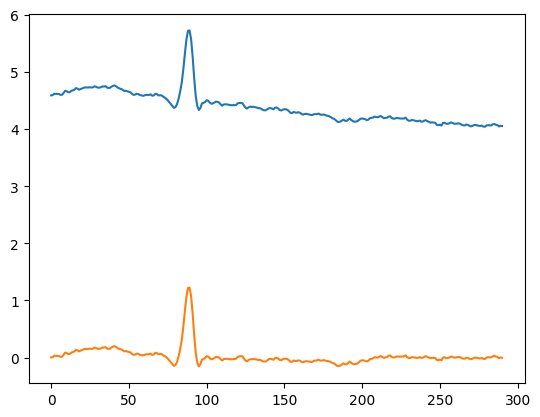

Running FIR fiter on the test set. This will take a while (2h)...
(FIR) Filtering signal 1 of 6727
(FIR) Filtering signal 2 of 6727
(FIR) Filtering signal 3 of 6727
(FIR) Filtering signal 4 of 6727
(FIR) Filtering signal 5 of 6727
(FIR) Filtering signal 6 of 6727
(FIR) Filtering signal 7 of 6727
(FIR) Filtering signal 8 of 6727
(FIR) Filtering signal 9 of 6727
(FIR) Filtering signal 10 of 6727
(FIR) Filtering signal 11 of 6727
(FIR) Filtering signal 12 of 6727
(FIR) Filtering signal 13 of 6727
(FIR) Filtering signal 14 of 6727
(FIR) Filtering signal 15 of 6727
(FIR) Filtering signal 16 of 6727
(FIR) Filtering signal 17 of 6727
(FIR) Filtering signal 18 of 6727
(FIR) Filtering signal 19 of 6727
(FIR) Filtering signal 20 of 6727
(FIR) Filtering signal 21 of 6727
(FIR) Filtering signal 22 of 6727
(FIR) Filtering signal 23 of 6727
(FIR) Filtering signal 24 of 6727
(FIR) Filtering signal 25 of 6727
(FIR) Filtering signal 26 of 6727
(FIR) Filtering signal 27 of 6727
(FIR) Filtering signal 28

<Figure size 640x480 with 0 Axes>

In [21]:
# -*- coding: utf-8 -*-
# ============================================================
#
#  BWL FIR Filtering
#  authors: David Castro Piñol, Francisco Perdigon Romero
#  email: davidpinyol91@gmail.com, fperdigon88@gmail.com
#  github id: Dacapi91, fperdigon
#
# ============================================================

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter
from datetime import datetime
import _pickle as pickle
from Data_Preparation.data_preparation import Data_Preparation

def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


if __name__ == "__main__":
    # signal for demonstration.
    ecgy = sio.loadmat('digitalFilters/ecgbeat.mat')
    signal = ecgy['ecgy']
    signal = list(signal[:,0])
    ## parameters
    Fs = 360
    Fc = 0.67
    factor = 2

    #ECG_Clean,N = FIRRemoveBL(signal,Fs,Fc,factor)

    ECG_Clean = IIRRemoveBL(signal,Fs, Fc)
    with open('./data/dataset_cinc.pkl', 'rb') as input:
        Dataset = pickle.load(input)
    X_train, y_train, X_test, y_test = Dataset
    plt.figure()
    plt.plot(signal[0:len(ecgy['ecgy'])])
    plt.plot(ECG_Clean)
    plt.show()
    plt.figure()
# Classical Filters
    train_time_list = []
    test_time_list = []
    # FIR
    print('Running FIR fiter on the test set. This will take a while (2h)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_FIR = [X_test_f, y_test_f, y_filter]

    # Save FIR filter results
    with open('cinc_test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_FIR, output)
    print('Results from experiment FIR filter saved')

    # IIR
    print('Running IIR fiter on the test set. This will take a while (25 mins)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_IIR = [X_test_f, y_test_f, y_filter]

    # Save IIR filter results
    with open('cinc_test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_IIR, output)
    print('Results from experiment IIR filter saved')

    # Saving timing list
    timing = [train_time_list, test_time_list]
    with open('cinc_timing.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(timing, output)
    print('Timing saved')

In [ ]:
from deepFilter.dl_pipeline import train_dl, test_dl

dl_experiments = ['Transformer_COMBDAE']
train_time_list = []
test_time_list = []
    
    # Get the current date in 'MMDD' format
current_date = datetime.now().strftime('%m%d')
for experiment in dl_experiments:
    # 데이터 준비 단계
    if experiment in ['Transformer_COMBDAE']:
        Dataset = Data_Preparation_with_Fourier_CINC(samples=512, fs=360)
        X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset         
    else:
        Dataset = Data_Preparation_CINC(samples=512)
        X_train, y_train, X_test, y_test = Dataset
    
    # 훈련 시간 측정 및 모델 훈련
    start_train = datetime.now()
    train_dl(Dataset, experiment)
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)
    # 테스트 시간 측정 및 모델 테스트
    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, experiment)
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)
    # 시각화 및 결과 저장
    save_dir = current_date 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    test_results = [X_test, y_test, y_pred]
    with open(os.path.join(save_dir, 'cinc_' + 'test_results_' + experiment + '.pkl'), 'wb') as output:
        pickle.dump(test_results, output)
    print('Results from experiment ' + experiment + ' saved')

2025-01-24 03:01:13.014623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 03:01:13.020355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737655273.026399 2772778 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737655273.028294 2772778 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 03:01:13.034993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Getting the Data ready ...
[INFO] Loaded CINC data: 193278 training beats, 6727 testing beats.
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing CINC data.
[INFO] rnd_test shape: (6727,)
[INFO] Final shapes -> X_train: (193278, 512, 1), y_train: (193278, 512, 1), X_test: (6727, 512, 1), y_test: (6727, 512, 1)
[INFO] Fourier shapes -> F_train_x: (193278, 512, 1), F_train_y: (193278, 512, 1), F_test_x: (6727, 512, 1), F_test_y: (6727, 512, 1)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp Transformer_COMBDAE


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737655289.598080 2772778 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22171 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1737655289.598563 2772778 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:06:00.0, compute capability: 8.9



 Transformer_COMBDAE
 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 16)   │          0 │ conv1d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256, 16)   │          0 │ activation_3[0][… │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_3[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 32)   │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,961,217 (7.48 MB)

 Trainable params: 1,960,545 (7.48 MB)

 Non-trainable params: 672 (2.62 KB)

Epoch 1/100000


I0000 00:00:1737655297.315193 2773235 service.cc:148] XLA service 0x7f0b30015fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737655297.315207 2773235 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1737655297.315209 2773235 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-01-24 03:01:37.516365: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737655298.389304 2773235 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-24 03:01:39.058416: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36_0', 52 bytes spill stores, 52 bytes spill loads

2025-01-24 03:01:39.213085: I external/local_xla/xla/stream_executo

  11/1057 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 625.2836 - mad_loss: 6.5185 - mean_absolute_error: 0.4425 - mean_squared_error: 0.5847 - ssd_loss: 299.3608   

I0000 00:00:1737655303.467069 2773235 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1052/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60.7417 - mad_loss: 0.6309 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0570 - ssd_loss: 29.1960

2025-01-24 03:01:55.589840: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36_0', 52 bytes spill stores, 52 bytes spill loads

2025-01-24 03:01:55.787176: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_39_0', 332 bytes spill stores, 324 bytes spill loads

2025-01-24 03:01:55.880616: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_39_0', 108 bytes spill stores, 108 bytes spill loads



1057/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 60.6398 - mad_loss: 0.6298 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0569 - ssd_loss: 29.1511
Epoch 1: val_loss improved from inf to 38.92185, saving model to 0124/Transformer_COMBDAE_weights.best.weights.h5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - loss: 60.6196 - mad_loss: 0.6295 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0569 - ssd_loss: 29.1422 - val_loss: 38.9218 - val_mad_loss: 0.3301 - val_mean_absolute_error: 0.1416 - val_mean_squared_error: 0.0438 - val_ssd_loss: 22.4148 - learning_rate: 0.0010
Epoch 2/100000
1054/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.9154 - mad_loss: 0.2747 - mean_absolute_error: 0.0974 - mean_squared_error: 0.0296 - ssd_loss: 15.1789
Epoch 2: val_loss improved from 38.92185 to 27.82731, saving model to 0124/Transformer_COMBDAE_weights.best.weights.h5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 28.9115 - mad_loss: 0.2747 - mean_absolute_error: 0.0974 - mean_sq

KeyboardInterrupt: 

: 

In [18]:
with open('0123/cinc_test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0123/cinc_test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results DeepFilter
with open('0123/cinc_test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0123/cinc_test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0123/cinc_test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0123/cinc_test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0123/cinc_test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0123/cinc_test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+------------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD        |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+------------------+---------------+----------------+
|      FIR Filter     | 74.853 (246.124) | 0.790 (0.774) | 79.733 (21.437)  | 0.582 (0.224) | -1.515 (4.880) |
|      IIR Filter     | 73.741 (255.441) | 0.798 (0.774) | 81.589 (20.723)  | 0.567 (0.223) | -1.582 (4.641) |
|         DRNN        | 21.663 (84.876)  | 0.466 (0.517) | 86.559 (58.835)  | 0.771 (0.185) | 4.896 (3.199)  |
|       FCN-DAE       | 36.596 (136.291) | 0.716 (0.580) | 225.818 (85.464) | 0.539 (0.208) | 1.247 (1.170)  |
|      DeepFilter     | 21.251 (89.099)  | 0.371 (0.436) | 82.942 (56.655)  | 0.803 (0.154) | 5.436 (3.412)  |
|   AttentionSkipDAE  | 16.557 (72.080)  | 0.329 (0.418) | 62.464 (39.630)  | 0.848 (0

In [20]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']
model_results = {}
# Load FIR and IIR results
with open('0123/cinc_test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('0123/cinc_test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

for model_name in dl_experiments:
    file_path = f"0123/cinc_test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)


# Load noise levels
rnd_test = np.load("rnd_test_cinc.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model by cinc: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final_cinc"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model by cinc: FIR_Filter
Processing results for model by cinc: IIR_Filter
Processing results for model by cinc: DRNN
Processing results for model by cinc: FCN-DAE
Processing results for model by cinc: DeepFilter
Processing results for model by cinc: AttentionSkipDAE
Processing results for model by cinc: Transformer_DAE
Processing results for model by cinc: Transformer_COMBDAE
Saved SSD table to results_tables_final_cinc/SSD_results.tex
Saved MAD table to results_tables_final_cinc/MAD_results.tex
Saved PRD table to results_tables_final_cinc/PRD_results.tex
Saved COS_SIM table to results_tables_final_cinc/COS_SIM_results.tex
Saved SNR table to results_tables_final_cinc/SNR_results.tex


# 진짜 시각화


0.2 ~ 2.0 구간별로 하고싶었다.


combdae로 구간별 비교

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot concatenated ECG segments with noise information and metrics
def plot_concatenated_ecg_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
    """
    Generates a single plot of concatenated Original, Noisy, and Filtered ECG signals for a given noise range.
    """
    # Concatenate all segments
    ecg_concat_original = np.concatenate(ecg_original)
    ecg_concat_noisy = np.concatenate(ecg_noisy)
    ecg_concat_filtered = np.concatenate(ecg_filtered)

    # Create a figure
    plt.figure(figsize=(14, 6))

    # Plot Original, Noisy, and Filtered signals
    plt.plot(ecg_concat_original, label='Original', color='red', linewidth=1.5)
    plt.plot(ecg_concat_noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0, alpha=0.8)
    plt.plot(ecg_concat_filtered, label='Filtered', color='green', linewidth=1.2, alpha=0.85)

    # Add metrics as text
    metrics_text = (
        f"SSD: {np.mean(metrics['SSD']):.2f}, "
        f"MAD: {np.mean(metrics['MAD']):.3f}, "
        f"PRD: {np.mean(metrics['PRD']):.2f}, "
        f"Cosine Sim: {np.mean(metrics['COS_SIM']):.3f}"
    )
    plt.title(f"Noise Range: {noise_range}\nMetrics: {metrics_text}", fontsize=24, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=14)
    plt.ylabel("Amplitude (a.u.)", fontsize=14)

    plt.legend(loc="upper right", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)

    # Save the image
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved plot: {save_path}")

# Load Transformer_COMBDAE results
with open("1208/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")

def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, and Cosine Similarity metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD
    mad = np.mean(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim}


# Loop through each noise segment range and each noise level
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    # Prepare metrics for this range
    metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": []}

    # Compute metrics for all samples in the range
    for idx in noise_indices:
        metrics = calculate_metrics(y_original=y_test[idx], y_filtered=y_pred[idx])
        for key, value in metrics.items():
            metrics_range[key].append(value)

    # Select up to 7 samples for visualization
    vis_indices = noise_indices[107:114]
    ecg_original = [y_test[idx].flatten() for idx in vis_indices]
    ecg_noisy = [X_test[idx].flatten() for idx in vis_indices]
    ecg_filtered = [y_pred[idx].flatten() for idx in vis_indices]

    # Save path for the plot
    save_dir = "view_comp_concat_plots"
    ensure_directory(save_dir)
    save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_concat_comparison.png")

    # Plot and save
    plot_concatenated_ecg_with_metrics(
        ecg_original, ecg_noisy, ecg_filtered, metrics_range,
        noise_range=f"{noise_start} < noise < {noise_end}",
        save_path=save_path
    )

    # Print metrics summary for this range
    print(f"Metrics for Noise Range {noise_start} to {noise_end}:")
    for key in metrics_range.keys():
        print(f"  {key}: Mean = {np.mean(metrics_range[key]):.4f}, Std = {np.std(metrics_range[key]):.4f}")


Saved plot: view_comp_concat_plots/Noise_0.2_0.6_concat_comparison.png
Metrics for Noise Range 0.2 to 0.6:
  SSD: Mean = 3.5897, Std = 5.6235
  MAD: Mean = 0.0409, Std = 0.0261
  PRD: Mean = 32.8091, Std = 14.1779
  COS_SIM: Mean = 0.9407, Std = 0.0581
Saved plot: view_comp_concat_plots/Noise_0.6_1.0_concat_comparison.png
Metrics for Noise Range 0.6 to 1.0:
  SSD: Mean = 4.2850, Std = 6.7194
  MAD: Mean = 0.0446, Std = 0.0257
  PRD: Mean = 37.6232, Std = 15.5198
  COS_SIM: Mean = 0.9214, Std = 0.0746
Saved plot: view_comp_concat_plots/Noise_1.0_1.5_concat_comparison.png
Metrics for Noise Range 1.0 to 1.5:
  SSD: Mean = 5.1525, Std = 8.2639
  MAD: Mean = 0.0486, Std = 0.0287
  PRD: Mean = 41.1454, Std = 17.4425
  COS_SIM: Mean = 0.9028, Std = 0.0988
Saved plot: view_comp_concat_plots/Noise_1.5_2.0_concat_comparison.png
Metrics for Noise Range 1.5 to 2.0:
  SSD: Mean = 6.7450, Std = 9.1653
  MAD: Mean = 0.0551, Std = 0.0312
  PRD: Mean = 46.8676, Std = 19.8337
  COS_SIM: Mean = 0.8735, S

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")
# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals
# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
def plot_model_differences_individual(model_results, vis_indices, noise_range, save_dir):
    """
    Plot differences for each model in individual plots.
    """
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        differences = [y_test[idx].flatten() - y_pred[idx].flatten() for idx in vis_indices]
        concatenated_diff = np.concatenate(differences)

        plt.figure(figsize=(14, 6))
        plt.plot(concatenated_diff, label=f'{model_name} Difference', color='blue', linewidth=1.5)

        plt.title(f"Difference Signal: {model_name}\nNoise Range: {noise_range}", fontsize=20, fontweight='bold')
        plt.xlabel("Sample Index", fontsize=14)
        plt.ylabel("Difference Amplitude (a.u.)", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()

        # Save individual plot
        save_path = os.path.join(save_dir, f"{model_name}_Noise_{noise_range.replace('<', '_')}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved individual plot for {model_name}: {save_path}")

# Noise range 처리 및 저장 경로 설정
save_dir_individual = "difference_plots_individual"
ensure_directory(save_dir_individual)

for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    vis_indices = noise_indices[:7]  # 최대 7개 샘플 선택
    noise_range_str = f"{noise_start} < noise < {noise_end}"

    plot_model_differences_individual(
        model_results, vis_indices, noise_range_str, save_dir_individual
    )


Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FCN-DAE: difference_plots_individual/FCN-DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Multibranch LANLD: difference_plots_individual/Multibranch LANLD_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for AttentionSkipDAE: difference_plots_individual/AttentionSkipDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_DAE: difference_plots_individual/Transformer_DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_COMBDAE: difference_plots_individual/Transformer_COMBDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FIR_Filter: difference_plots_individual/FIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for IIR_Filter: difference_plots_individual/IIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.6 _ noise _ 1.0.png
Saved individual plot for FCN-D

In [ ]:
print("Noise Indices for each range:")
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]
    print(f"Range {noise_start}-{noise_end}: Indices = {noise_indices}")


Noise Indices for each range:
Range 0.2-0.6: Indices = [    0     1     4 ... 13308 13312 13315]
Range 0.6-1.0: Indices = [   11    12    17 ... 13299 13301 13313]
Range 1.0-1.5: Indices = [    2     9    15 ... 13304 13307 13310]
Range 1.5-2.0: Indices = [    3     6     8 ... 13309 13311 13314]


밑에껀 샘플별 따로

In [ ]:
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# # Noise combination descriptions for labels
# NOISE_COMBINATIONS = {
#     1: "Baseline Wander (BW) only",
#     2: "Electrode Motion (EM) only",
#     3: "Muscle Artifact (MA) only",
#     4: "BW + EM",
#     5: "BW + MA",
#     6: "EM + MA",
#     7: "BW + EM + MA"
# }

# # Noise levels for testing
# segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# # Ensure directory for saving images exists
# def ensure_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # Function to plot concatenated ECG segments with noise information and metrics
# def plot_ecg_segments_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics, noise_range, save_path):
#     """
#     Generates a side-by-side plot of Original, Noisy, and Filtered ECG signals for a given noise range.
#     """
#     plt.figure(figsize=(10, 12))  # Adjust figure size for better visibility

#     # Plotting for each noise range
#     for i, (original, noisy, filtered) in enumerate(zip(ecg_original, ecg_noisy, ecg_filtered)):
#         ax = plt.subplot(len(ecg_original), 1, i + 1)
        
#         # Plot Original, Noisy, and Filtered signals
#         ax.plot(original, label='Original', color='red', linewidth=1.5)
#         ax.plot(noisy, label='Noisy', color='blue', linestyle='--', linewidth=1.0)
#         ax.plot(filtered, label='Filtered', color='green', linewidth=1.2)
        
#         # Adding metrics as text
#         metrics_text = (
#             f"SSD: {metrics['SSD'][i]:.2f}, "
#             f"MAD: {metrics['MAD'][i]:.3f}, "
#             f"PRD: {metrics['PRD'][i]:.2f}, "
#             f"Cosine Sim: {metrics['COS_SIM'][i]:.3f}"
#         )
#         ax.text(0.98, 0.95, metrics_text, transform=ax.transAxes, fontsize=9,
#                 verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
        
#         ax.set_title(f"Noise Range: {noise_range[i]}")
#         ax.set_xlabel("Samples")
#         ax.set_ylabel("Amplitude (a.u.)")
#         ax.legend(loc="upper right", fontsize=10)
#         ax.grid(True, linestyle=':', alpha=0.5)

#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300)
#     plt.close()
#     print(f"Saved plot: {save_path}")

# # Load Transformer_COMBDAE results
# with open("1030/test_results_Transformer_COMBDAE.pkl", "rb") as input_file:
#     X_test, y_test, y_pred = pickle.load(input_file)

# # Load rnd_test (noise levels)
# rnd_test = np.load("rnd_test.npy")

# # Example metrics for demonstration
# metrics_demo = {
#     "SSD": np.random.uniform(9.0, 11.0, len(rnd_test)),
#     "MAD": np.random.uniform(0.25, 0.30, len(rnd_test)),
#     "PRD": np.random.uniform(14.0, 15.0, len(rnd_test)),
#     "COS_SIM": np.random.uniform(0.98, 1.0, len(rnd_test))
# }

# # Select specific noise ranges and indices
# for i in range(len(segm) - 1):
#     noise_start, noise_end = segm[i], segm[i + 1]
#     noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0][:7]  # Limit to 7 segments

#     if len(noise_indices) == 0:
#         print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
#         continue

#     # Prepare data for plotting
#     ecg_original = [y_test[idx].flatten() for idx in noise_indices]
#     ecg_noisy = [X_test[idx].flatten() for idx in noise_indices]
#     ecg_filtered = [y_pred[idx].flatten() for idx in noise_indices]

#     # Metrics for current range
#     metrics_range = {key: [val[idx] for idx in noise_indices] for key, val in metrics_demo.items()}

#     # Save path for the plot
#     save_dir = "view_comp_plots"
#     ensure_directory(save_dir)
#     save_path = os.path.join(save_dir, f"Noise_{noise_start}_{noise_end}_comparison.png")

#     # Plot and save
#     plot_ecg_segments_with_metrics(ecg_original, ecg_noisy, ecg_filtered, metrics_range,
#                                    noise_range=f"{noise_start} < noise < {noise_end}",
#                                    save_path=save_path)
